In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan
import arviz as az
import pickle
from hashlib import md5

In [2]:
sns.set()

In [3]:
#from Stan tutorial, pickles compiled stan model into cache.
def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm 

In [4]:
#function for getting nicer plots for diagnostics, showing statistical parameters and distributions of data
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

## Linear Function Data

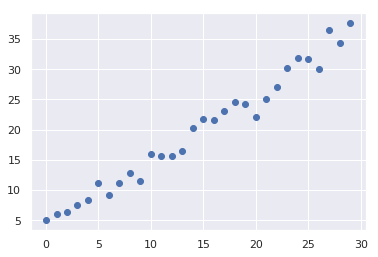

In [33]:
stan_model_lin = """
data{
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters{
    real alpha;
    real beta;
    real<lower=0> sigma;   
}
model{
    y ~ normal(alpha + beta * x, sigma);
}
"""
N= 30
x = []
for i in range(0,N):
    l = i
    x.append(l)
    
y = []
for i in range(0,N):
    l = 5+i+np.random.normal(0, 0.4*np.sqrt(i))
    y.append(l)


data = {'N':N,
            'x':x,
            'y':y,}

plt.scatter(x,y)
plt.show()

In [34]:
sm = StanModel_cache(model_code = stan_model_lin, Model_name="CachedModelLinear")
fit = sm.sampling(data=data, iter=1000, chains=4)
print(fit)


Using cached StanModel
Inference for Stan model: anon_model_2c01a698b54812316fb274b92c2fa8db.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.91    0.02   0.56   2.81   3.54    3.9   4.27   5.02   1048    1.0
beta     1.1  1.1e-3   0.03   1.03   1.08    1.1   1.12   1.17   1017    1.0
sigma   1.57  7.2e-3   0.22   1.21   1.42   1.55   1.71   2.07    943    1.0
lp__  -27.49    0.05    1.3 -30.69 -28.06 -27.16 -26.58 -26.04    621    1.0

Samples were drawn using NUTS at Thu Nov  7 17:24:32 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f24bca58160>,
      dtype=object)

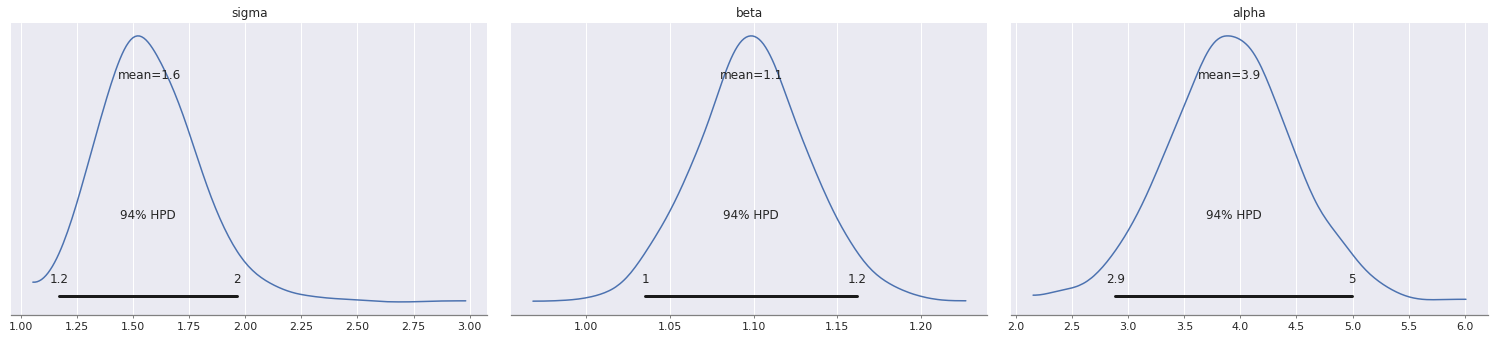

In [35]:
az.plot_posterior(fit)

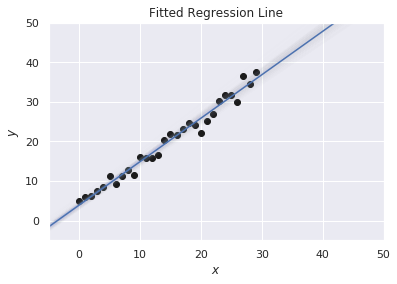

In [37]:
#define variables reading values from fit object from stan evaluation
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

#calculate alpha and beta means
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']


#plot regression line
x_min, x_max = -5, 50
x_plot = np.linspace(x_min, x_max, 100)

#plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(100):
      plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
           alpha=0.015 )

#plot mean regression line, grid, data points
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y, c='k')
plt.grid(True)
plt.ylim(-5,50)
plt.xlim(-5,50)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.show()

## Periodic Function Data

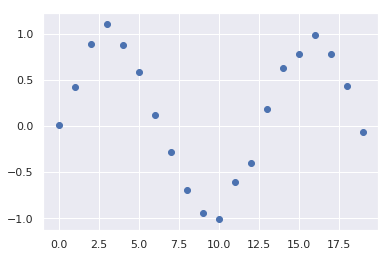

In [46]:
periodic = """
data{
    int<lower=1> N;
    matrix[N,N] x2;
    vector[N] y2;
}
parameters{
    real alpha;
    vector[N] beta;
    real<lower=0> sigma;
}
model{
    y2 ~ normal(x2*beta + alpha, sigma);
}
"""

N = 20

def rbf(h1, h2):
    return np.sin(np.square(h1-h2))

x2 = np.zeros(shape=(N,N))
for n1 in range(N):
    for n2 in range(N):
        x2[n1, n2] = rbf(x[n1], x[n2])

x2lin = []
for i in range(0,N):
    l=i
    x2lin.append(l)

y2 = []
for i in range(0,N):
    l= np.sin(i/2) + np.random.normal(0, 0.1)
    y2.append(l)
    
data={'N':N, 
      'y2':y2, 
      'x2':x2}

plt.scatter(x2lin,y2)

In [47]:
sm = StanModel_cache(model_code = periodic, Model_name="CachedModelExp")
fit = sm.sampling(data=data, iter=1000, chains=4)
print(fit)

Using cached StanModel


Inference for Stan model: anon_model_36a9ede193d2dfac407d572506a0a757.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -6.2e8   1.6e9  3.0e9 -8.2e9 -7.9e8  2.6e7  1.2e9  3.1e9      3   2.85
beta[1]  -2.6e8   4.2e8  9.1e8 -2.4e9 -4.9e8  4.5e6  2.3e8  1.1e9      5   1.61
beta[2]  -6.2e8   9.9e8  2.0e9 -5.1e9 -1.3e9  1.3e7  6.1e8  1.9e9      4   2.28
beta[3]  -6.0e8   1.4e9  2.5e9 -6.8e9 -6.2e8  2.6e7  8.5e8  2.5e9      3   2.52
beta[4]  -2.5e8   1.0e9  1.9e9 -5.0e9 -1.5e8  2.1e7  9.1e8  2.1e9      3   2.71
beta[5]   2.1e8   3.9e8  8.8e8 -1.7e9  3.1e5  5.0e7  5.7e8  2.2e9      5   1.96
beta[6]   2.9e8   2.0e8  7.2e8 -7.9e8 -9.7e7 -1.1e6  6.8e8  1.9e9     13   1.29
beta[7]   1.3e7   2.2e8  7.1e8 -1.9e9 -1.3e8 -1.5e6  2.6e8  1.5e9     10   1.27
beta[8]  -1.4e8   1.8e8  7.5e8 -1.9e9 -4.7e8  2.2e6  2.1e8  1.5e9     18   1.26
beta[9]  -4.8

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f24bc9447f0>,
      dtype=object)

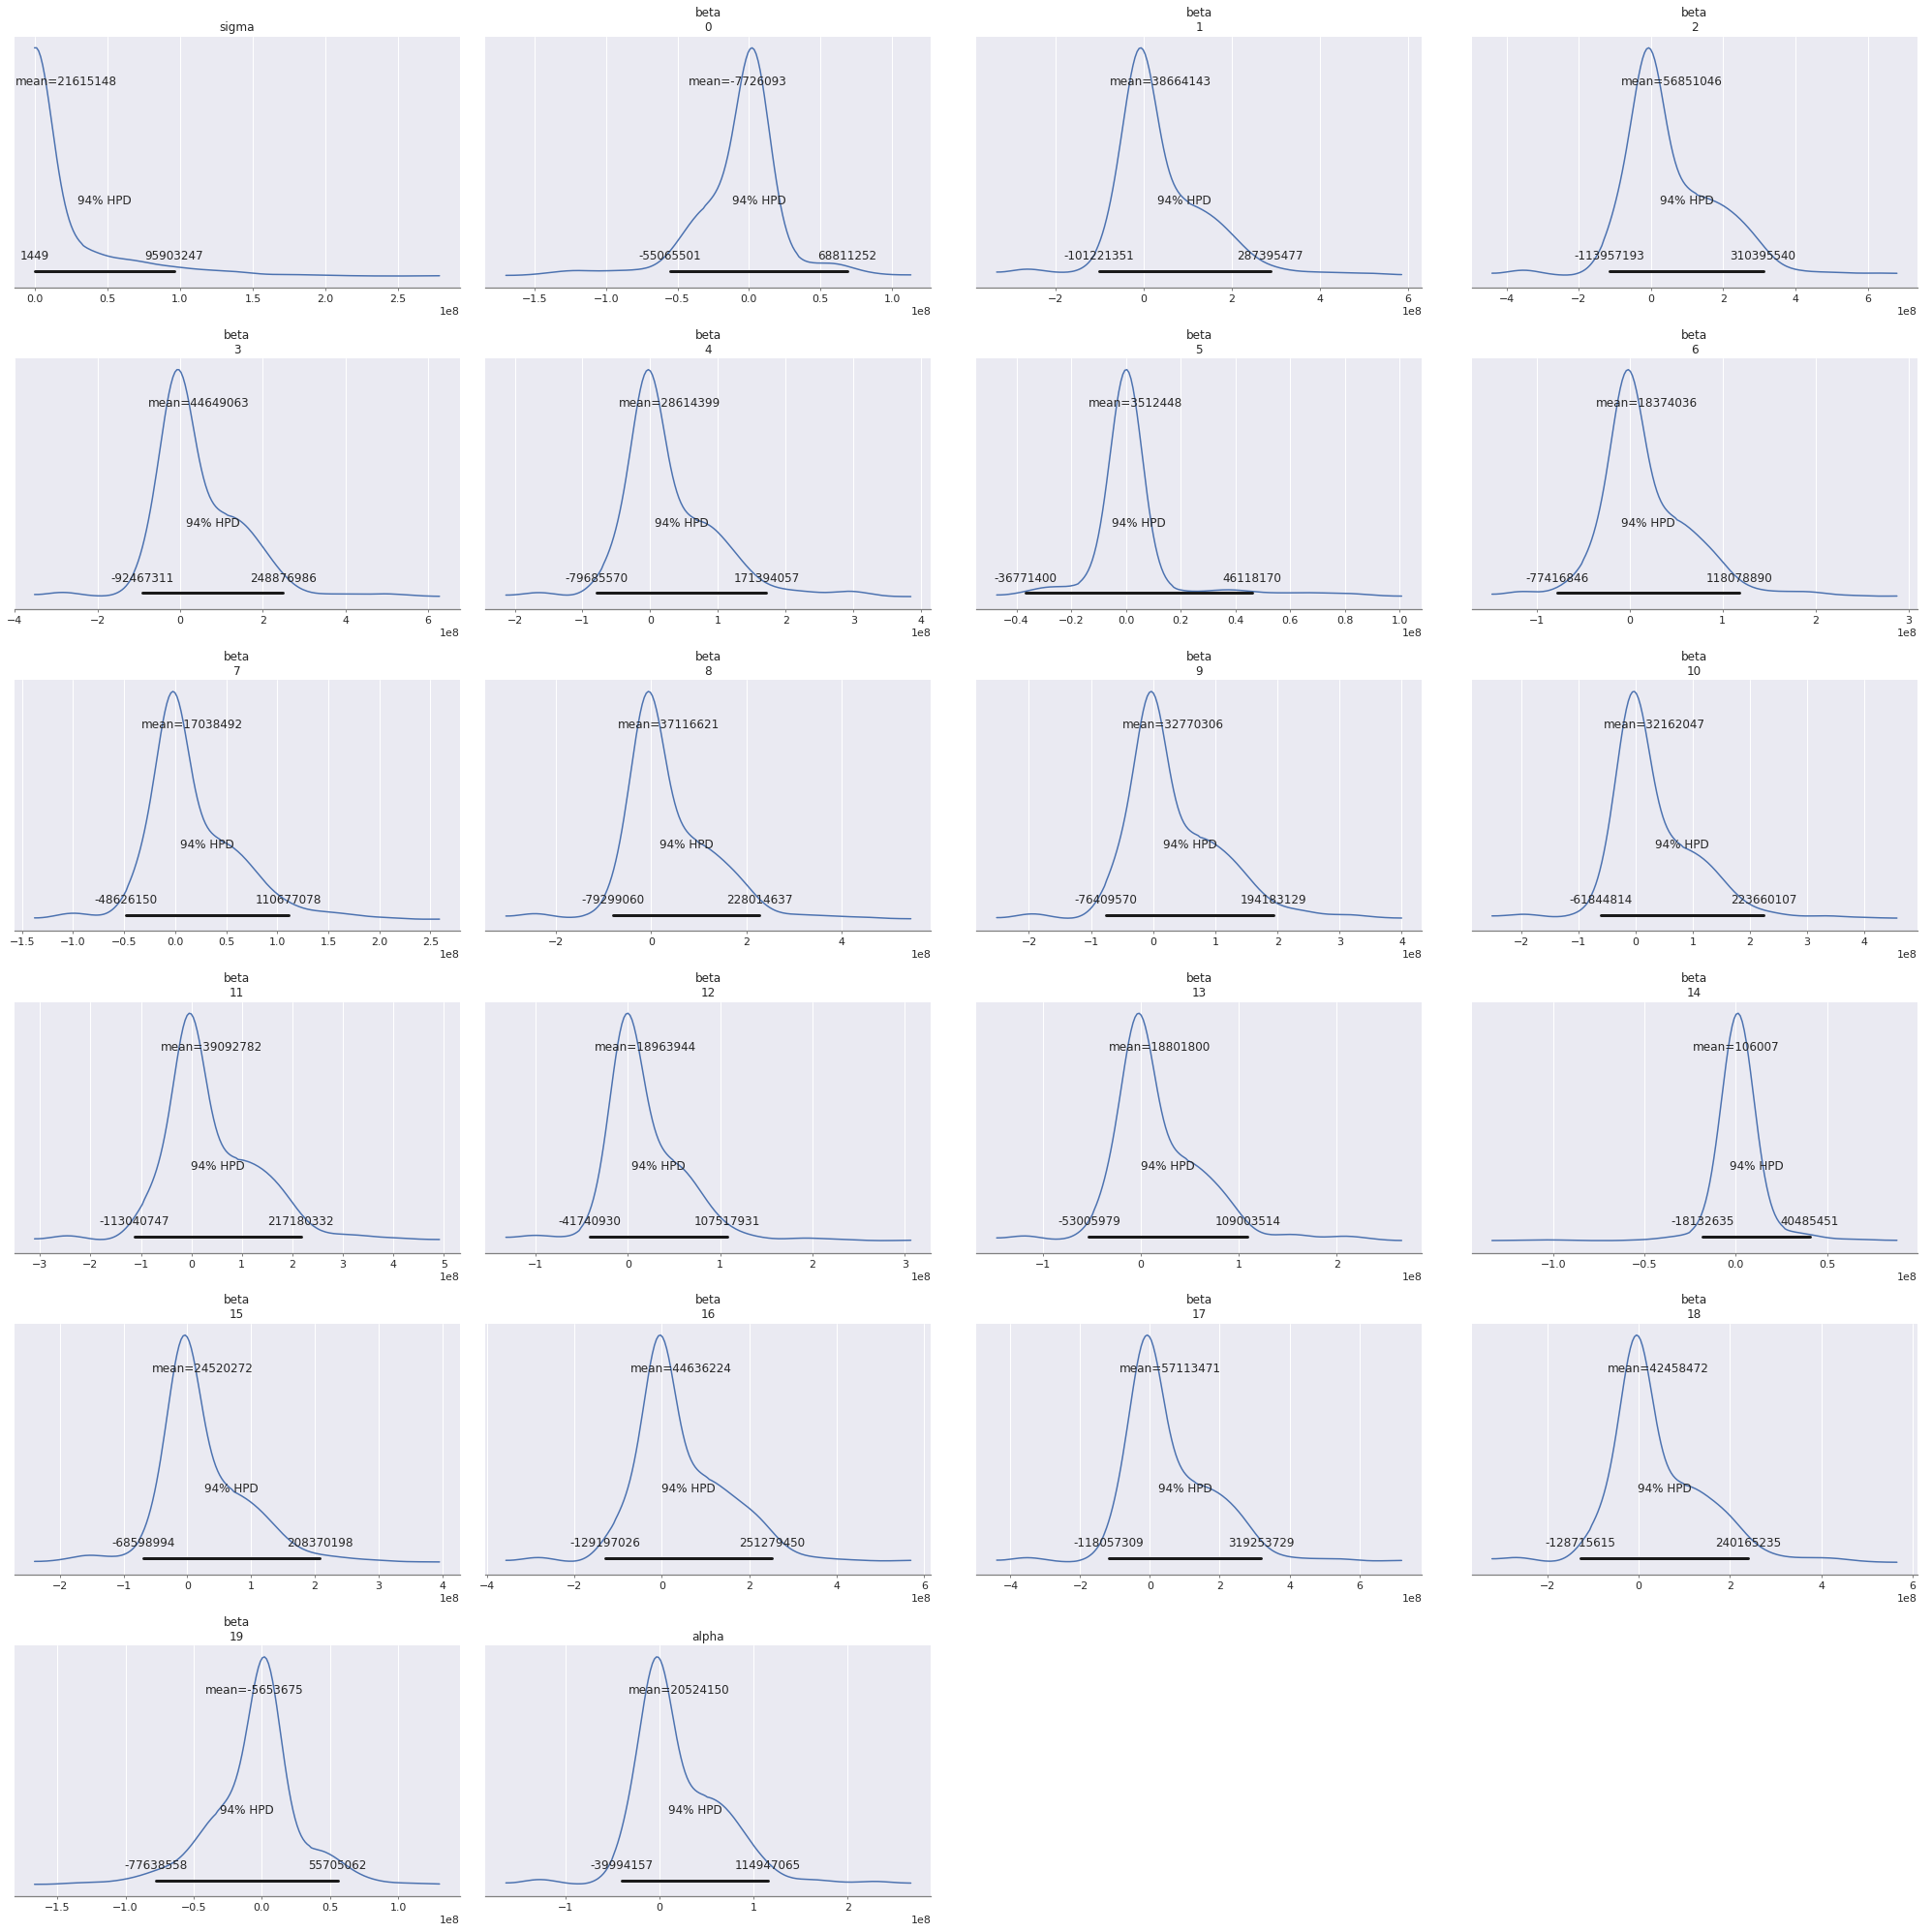

In [27]:
az.plot_posterior(fit)

# Gaussian Process

In [ ]:
gauss = """
data{

}
transformed data{

}
parameters{

}
model{

}

"""

